IA & Data science -- 2017-2018
--------
*&copy; Equipe pédagogique: Ludovic Denoyer, Thibault Laugel, Marie-Jeanne Lesot, Christophe Marsala, Olivier Schwander*

# TD-TME06: méthodes d'ensembles

L'objectif de ce TP est d'implémenter des méthodes d'ensembles et de les évaluer: l'algorithme de bagging appliqué aux arbres de décision, dans un premier temps, puis au perceptron ensuite.

Comme précédemment, on se restreint au cas binaire où les données sont étiquetées $+1$ ou $-1$. De plus, on ne considére que le cas où les attributs sont tous numériques.

<font size="+1">**[Q]**</font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

Harb Hassan et Clément Chrétien

<font color="RED" size="+1">IMPORTANT: soumission de votre fichier final</font>

**Nom à donner au fichier à poster** : *Nom1_Nom2.ipynb* 
- *Nom1* et *Nom2* : noms des membres du binôme
- ne pas compresser ou faire une archive: envoyer le fichier ipython tel quel, éventuellement, si vous avez d'autres fichiers à envoyer, vous les joignez au message.

## Questions de cours (à faire chez vous, sur papier)

Pour vous entraîner sans machine... *(exercice de l'examen 2017)*

Soit $V=\{v_{1}, v_{2},..., v_{n}\}$ un ensemble de $n$ valeurs réelles ordonnées,
  telles que $v_1 \geq v_2 \geq \ldots \geq v_{n}$.. On note $\bar{v}$ la valeur moyenne de $V$. La variance de $V$, $var(V)$ est définie par:
$var(V) = \frac{1}{n} \sum_{i=1}^{n} (v_{i} - \bar{v})^2$. 

Et soit $W=\{w_{1}, w_{2},..., w_{n}\}$ tel que,pour tout $i=1,...,n$.


** [Q] ** Donner l'expression de $\bar{v}$ en fonction des valeurs de $V$.

** [Q] **  Montrer que $var(aV+b) = a^2 var(V)$.

** [Q] ** Donner l'expression de $V\cdot W$ (le produit scalaire) en fonction des coordonnées
   de $V$ et de $W$.
   
** [Q] ** Comment doit-on définir $W$ si on souhaite que $V\cdot W = \bar{v}$ ?


** [Q] ** Comment doit-on définir $W$ si on souhaite que
   $V\cdot W = \displaystyle\max_{i=1,...n} v_i$ ? Même question si on souhaite que
   $V\cdot W = \displaystyle\min_{i=1,...n} v_i$ ?

** [Q] ** Soit un entier $k$ tel que $0<k\leq n$. Proposer une définition de $W$ qui, par le
   calcul du produit scalaire, permet de ne tenir compte, de façon équitable, que des $k$
   valeurs les plus élevées de $V$.



## Préparation


In [1]:
#imports utiles
import numpy as np
import pandas as pd

On utilise la classe <code>LabeledSet</code> pour stocker les données d'apprentissage, de validation et de test.

In [2]:
class LabeledSet:  
    
    def __init__(self, input_dimension):
        self.input_dimension = input_dimension
        self.nb_examples = 0
    
    def addExample(self,vector,label):
        if (self.nb_examples == 0):
            self.x = np.array([vector])
            self.y = np.array([label])
        else:
            self.x = np.vstack((self.x, vector))
            self.y = np.vstack((self.y, label))
        
        self.nb_examples = self.nb_examples + 1
    
    #Renvoie la dimension de l'espace d'entrée
    def getInputDimension(self):
        return self.input_dimension
    
    #Renvoie le nombre d'exemples dans le set
    def size(self):
        return self.nb_examples
    
    #Renvoie la valeur de x_i
    def getX(self, i):
        return self.x[i]
        
    
    #Renvouie la valeur de y_i
    def getY(self, i):
        return(self.y[i])

Pour tester les fonctions à implémenter dans cette séance, on utilise la base d'exemples suivante :

In [3]:
# Base d'exemples pour tester les fonctions:
set_exemples = LabeledSet(2)
set_exemples.addExample([2.10492662303,1.10648470933],1)
set_exemples.addExample([0.297525816499,-0.662504551625],1)
set_exemples.addExample([1.6694258992,0.313687975072],1)
set_exemples.addExample([1.20583098523,3.50817309097],1)
set_exemples.addExample([1.13739407316,1.96688273992],1)
set_exemples.addExample([2.32319808376,0.536577798714],1)
set_exemples.addExample([-0.953004346997,0.596926923927],1)
set_exemples.addExample([1.00574784804,-0.0959606771199],1)
set_exemples.addExample([0.747509778063,0.429544908608],1)
set_exemples.addExample([1.39048336283,0.442578873406],1)
set_exemples.addExample([0.0470799329584,-1.97596265858],-1)
set_exemples.addExample([-0.673998013071,0.0693931940855],-1)
set_exemples.addExample([-0.84587451642,0.761766191612],-1)
set_exemples.addExample([-1.39596839858,-0.943807082082],-1)
set_exemples.addExample([0.319301767707,0.566169775123],-1)
set_exemples.addExample([1.43459714786,0.935712030926],-1)
set_exemples.addExample([-1.69323475458,-1.89563184035],-1)
set_exemples.addExample([0.81167008598,-1.17927660655],-1)
set_exemples.addExample([-1.03264043689,-1.08118488864],-1)
set_exemples.addExample([0.609517439986,-2.88593327349],-1)

Pour afficher, nous utilisons la fonction <code>plot2DSet()</code> déjà vue dans les séances précédentes. 


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline 

def plot2DSet(set):
    """ LabeledSet -> NoneType
        Hypothèse: set est de dimension 2
        affiche une représentation graphique du LabeledSet
        remarque: l'ordre des labels dans set peut être quelconque
    """
    S_pos = set.x[np.where(set.y == 1),:][0]      # tous les exemples de label +1
    S_neg = set.x[np.where(set.y == -1),:][0]     # tous les exemples de label -1
    plt.scatter(S_pos[:,0],S_pos[:,1],marker='o')
    plt.scatter(S_neg[:,0],S_neg[:,1],marker='x')


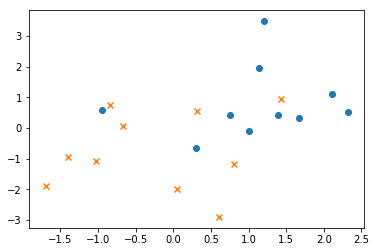

In [5]:
# Essai de la fonction : (the_set : variable du dataset généré précédemment)
plot2DSet(set_exemples)

### Les classifieurs

On reprend ici la classe <code>Classifier</code> qui sert encore de classe de base pour implémenter un nouveau classifieur.

In [6]:
class Classifier:
    def __init__(self,input_dimension):
        """ Constructeur """
        raise NotImplementedError("Please Implement this method")
    
    
    # Permet de calculer la prediction sur x => renvoie un score
    def predict(self,x):
        raise NotImplementedError("Please Implement this method")

    
    # Permet d'entrainer le modele sur un ensemble de données étiquetés
    def train(self,labeledSet):
        raise NotImplementedError("Please Implement this method")
    
    # Permet de calculer le taux de bonne classification
    def accuracy(self,set):
        nb_ok=0
        for i in range(set.size()):
            score = self.predict(set.getX(i))
            if (score*set.getY(i)>0):
                nb_ok = nb_ok+1
        acc = nb_ok/(set.size() * 1.0)
        return acc


On reprend aussi la fonction <code>plot_frontiere</code> pour dessiner la frontière de décision d'un classifieur. 

In [7]:
def plot_frontiere(set,classifier,step=10):
    """ LabeledSet * Classifier * int -> NoneType
        Remarque: le 3e argument est optionnel et donne la "résolution" du tracé
        affiche la frontière de décision associée au classifieur
    """
    mmax=set.x.max(0)
    mmin=set.x.min(0)
    x1grid,x2grid=np.meshgrid(np.linspace(mmin[0],mmax[0],step),np.linspace(mmin[1],mmax[1],step))
    grid=np.hstack((x1grid.reshape(x1grid.size,1),x2grid.reshape(x2grid.size,1)))
    
    # calcul de la prediction pour chaque point de la grille
    res=np.array([classifier.predict(grid[i,:]) for i in range(len(grid)) ])
    res=res.reshape(x1grid.shape)
    # tracer des frontieres
    plt.contourf(x1grid,x2grid,res,colors=["red","cyan"],levels=[-1000,0,1000],linewidth=2)

## Etape 1: Bagging d'arbres de décision

Dans cette étape, on procède à l'implémentation de l'algorithme du bagging. Dans un premier temps, le classifieur que l'on utilise est celui des arbres de décision.

### Classifieurs par arbres de décision
Reprendre ici les fonctions réalisées pour l'implémentation des arbres de décision : <code>classe_majoritaire()</code>, <code>shannon()</code>, <code>entropie()</code>, <code>discretise()</code>, <code>divise()</code>, et <code>construit_AD()</code>.
Ainsi que les classes <code>ArbreBinaire</code> et <code>ArbreDecision</code>.


In [8]:
def classe_majoritaire(labeledSet):
    a = sum(1 for i in range(labeledSet.nb_examples) if labeledSet.getY(i) == 1)  # Nombre d'exemple ayant pour classe +1
    b = sum(1 for i in range(labeledSet.nb_examples) if labeledSet.getY(i) == -1)
    if b > a:   # Si il y a plus d'exemple de la classe -1 alors on retourne -1 sinon 1 
        return -1
    else:
        return 1
    
    
def shannon(l):
    return -sum(i*math.log(i, len(l)) for i in l if i > 0)  # Somme des donnees de la liste donnee en argument a l'aide
                                                            # de la formule donnee
    
def entropie(labeledSet):
    a = sum(1 for i in range(labeledSet.nb_examples) if labeledSet.getY(i) == 1)  # Nombre d'exemple ayant pour classe +1 
    b = sum(1 for i in range(labeledSet.nb_examples) if labeledSet.getY(i) == -1)  
    return shannon([float(a)/(a+b), float(b)/(a+b)])  # Taux de presence de chaque classe d'exemple


def discretise(LSet, col):
    """ LabelledSet * int -> tuple[float, float]
        col est le numéro de colonne sur X à discrétiser
        rend la valeur de coupure qui minimise l'entropie ainsi que son entropie.
    """
    # initialisation:
    min_entropie = 1.1  # on met à une valeur max car on veut minimiser
    min_seuil = 0.0     
    # trie des valeurs:
    ind= np.argsort(LSet.x,axis=0)
    
    # calcul des distributions des classes pour E1 et E2:
    inf_plus  = 0               # nombre de +1 dans E1
    inf_moins = 0               # nombre de -1 dans E1
    sup_plus  = 0               # nombre de +1 dans E2
    sup_moins = 0               # nombre de -1 dans E2       
    # remarque: au départ on considère que E1 est vide et donc E2 correspond à E. 
    # Ainsi inf_plus et inf_moins valent 0. Il reste à calculer sup_plus et sup_moins 
    # dans E.
    for j in range(0,LSet.size()):
        if (LSet.getY(j) == -1):
            sup_moins += 1
        else:
            sup_plus += 1
    nb_total = (sup_plus + sup_moins) # nombre d'exemples total dans E
    
    # parcours pour trouver le meilleur seuil:
    for i in range(len(LSet.x)-1):
        v_ind_i = ind[i]   # vecteur d'indices
        courant = LSet.getX(v_ind_i[col])[col]
        lookahead = LSet.getX(ind[i+1][col])[col]
        val_seuil = (courant + lookahead) / 2.0;
        # M-A-J de la distrib. des classes:
        # pour réduire les traitements: on retire un exemple de E2 et on le place
        # dans E1, c'est ainsi que l'on déplace donc le seuil de coupure.
        if LSet.getY(ind[i][col])[0] == -1:
            inf_moins += 1
            sup_moins -= 1
        else:
            inf_plus += 1
            sup_plus -= 1
        # calcul de la distribution des classes de chaque côté du seuil:
        nb_inf = (inf_moins + inf_plus)*1.0     # rem: on en fait un float pour éviter
        nb_sup = (sup_moins + sup_plus)*1.0     # que ce soit une division entière.
        # calcul de l'entropie de la coupure
        val_entropie_inf = shannon([inf_moins / nb_inf, inf_plus  / nb_inf])
        val_entropie_sup = shannon([sup_moins / nb_sup, sup_plus  / nb_sup])
        val_entropie = (nb_inf / nb_total) * val_entropie_inf + (nb_sup / nb_total) * val_entropie_sup
        # si cette coupure minimise l'entropie, on mémorise ce seuil et son entropie:
        if (min_entropie > val_entropie):
            min_entropie = val_entropie
            min_seuil = val_seuil
    return (min_seuil, min_entropie)


def divise(LSet,att,seuil):
    """ LSet: LabeledSet
        att : numéro d'attribut
        seuil : valeur de seuil
        rend le tuple contenant les 2 sous-LabeledSet obtenus par la
        division de LSet selon le seuil sur l'attribut att
    """
    a = LabeledSet(2)
    b = LabeledSet(2)
    for i in range(LSet.size()):  # Pour chaque exemple on le range dans l'un des deux labeledSet
        if LSet.getX(i)[att] <= seuil:  # Si il se trouve en dessous du seuil on le met dans l'un sinon dans l'autre
            a.addExample(LSet.getX(i), LSet.getY(i))
        else:
            b.addExample(LSet.getX(i), LSet.getY(i))
    return a, b  # Tuple contenant les deux labeledSet crees
    
    
import graphviz as gv
import math

class ArbreBinaire:
    def __init__(self):
        self.attribut = None   # numéro de l'attribut
        self.seuil = None
        self.inferieur = None # ArbreBinaire Gauche (valeurs <= au seuil)
        self.superieur = None # ArbreBinaire Droit (valeurs > au seuil)
        self.classe = None # Classe si c'est une feuille: -1 ou +1
        
    def est_feuille(self):
        """ rend True si l'arbre est une feuille """
        return self.seuil == None
    
    def ajoute_fils(self,ABinf,ABsup,att,seuil):
        """ ABinf, ABsup: 2 arbres binaires
            att: numéro d'attribut
            seuil: valeur de seuil
        """
        self.attribut = att
        self.seuil = seuil
        self.inferieur = ABinf
        self.superieur = ABsup
    
    def ajoute_feuille(self,classe):
        """ classe: -1 ou + 1
        """
        self.classe = classe
        
    def classifie(self,exemple):
        """ exemple : numpy.array
            rend la classe de l'exemple: +1 ou -1
        """
        if self.est_feuille():
            return self.classe
        if exemple[self.attribut] <= self.seuil:
            return self.inferieur.classifie(exemple)
        return self.superieur.classifie(exemple)
    
    def to_graph(self, g, prefixe='A'):
        """ construit une représentation de l'arbre pour pouvoir
            l'afficher
        """
        if self.est_feuille():
            g.node(prefixe,str(self.classe),shape='box')
        else:
            g.node(prefixe, str(self.attribut))
            self.inferieur.to_graph(g,prefixe+"g")
            self.superieur.to_graph(g,prefixe+"d")
            g.edge(prefixe,prefixe+"g", '<='+ str(self.seuil))
            g.edge(prefixe,prefixe+"d", '>'+ str(self.seuil))
        
        return g
    
    
def construit_AD(LSet,epsilon):
    """ LSet : LabeledSet
        epsilon : seuil d'entropie pour le critère d'arrêt 
    """
    arbre = ArbreBinaire()  # On cree un arbreBinaire
     
        
    if entropie(LSet) <= epsilon:  # Si l'entropie du lset est inferieur ou egal a l'epsilon que l'on a fixe 
        arbre.ajoute_feuille(classe_majoritaire(LSet))  # On ajoute une feuille qui aura pour label la classe majoritaire
        return arbre  # On renvoie l'arbre 
    
    
    else:
        min_ent = 2  # On fixe une entropie a 2 de cette facon on est certain de trouver plus petit
        min_seuil = -1  
        att = -1
        
        for i in range(len(LSet.getX(0))):  # Pour le nombre d'attribut du set
            d = discretise(LSet, i)  # On discretise cet attribut
            if min_ent > d[1]:  # Si l'entropie est plus petite
                min_ent = d[1]
                min_seuil = d[0]
                att = i
                
        new_lset1, new_lset2 = divise(LSet, att, min_seuil)  # On cree 2 lset grace au parametre recuperer precedement
        
        #  On ajoute a l'arbre deux fils qui seront eux même des feuilles ou des arbres
        arbre.ajoute_fils(construit_AD(new_lset1, epsilon), construit_AD(new_lset2, epsilon), att, min_seuil)
        return arbre
        
        
        
class ArbreDecision(Classifier):
    # Constructeur
    def __init__(self,epsilon):
        # valeur seuil d'entropie pour arrêter la construction
        self.epsilon= epsilon
        self.racine = None
    
    # Permet de calculer la prediction sur x => renvoie un score
    def predict(self,x):
        # classification de l'exemple x avec l'arbre de décision
        # on rend 0 (classe -1) ou 1 (classe 1)
        classe = self.racine.classifie(x)
        if (classe == 1):
            return(1)
        else:
            return(-1)
    
    # Permet d'entrainer le modele sur un ensemble de données
    def train(self,set):
        # construction de l'arbre de décision 
        self.set=set
        self.racine = construit_AD(set,self.epsilon)

    # Permet d'afficher l'arbre
    def plot(self):
        gtree = gv.Digraph(format='png')
        return self.racine.to_graph(gtree)
        

Ainsi, vous devez donc pouvoir utiliser à partir d'ici la classe <code>ArbreDecision</code>.

Par exemple, sur la base <code>set_exemples</code>:

('accuracy:', 1.0)


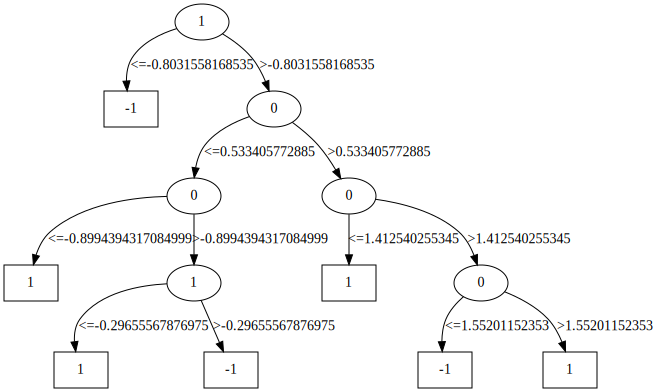

In [9]:
# un exemple d'utilisation:
ad=ArbreDecision(0.0)               # initialisation d'un arbre binaire qui utilise epsilon= 0.0
ad.train(set_exemples)              # construction de l'arbre à partir de la base jouet

print("accuracy:", ad.accuracy(set_exemples))    

#test de l'affichage 
ad.plot()


### Tirage aléatoire d'exemples

Le bootstrap s'effectue en tirant aléatoirement un échantillon de $m$ exemples à partir de la base d'apprentissage $X$ à partir duquel, on construit un classifieur.
Ce processus est répété $B$ fois.

Afin de ne pas alourdir la place mémoire nécessaire pour réaliser un tel tirage, on ne travaille que sur les indices des exemples dans la base. Un **échantillon de $X$ est donc un vecteur d'entiers** qui représentent les indices des exemples choisis.


#### Tirages aléatoires en Python

Consulter la librairie Python random qui propose différentes fonctions utiles pour implémenter le tirage aléatoire du bootstrap.

Par exemple, la fonction <code>sample()</code> de la librairie <code>random</code> rend une sélection aléatoire dans une population donnée en réalisant un tirage sans remise.

Pour tester, exécuter plusieurs fois les instructions de la boîte suivante :

In [10]:
import random
L= [i for i in range(0,11)]             # construction de la liste des entiers de 0 à 10
print("La liste L de depart: ",L)
EchL = random.sample(L,6)               # tirage de 6 éléments de L
print("Echantillon: ",EchL)

('La liste L de depart: ', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
('Echantillon: ', [9, 5, 6, 1, 0, 3])


La fonction <code>choice()</code> permet de choisir aléatoirement un élément:

In [11]:
L= [i for i in range(0,11)]             # construction de la liste des entiers de 0 à 10
print("La liste L de depart: ",L)
elt = random.choice(L)                  # choix d'un élémént
print("Element choisi: ",elt)

('La liste L de depart: ', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
('Element choisi: ', 8)


<font size="+1">**[Q]**</font> Ecrire une fonction <code>tirage()</code> qui étant donné un vecteur d'entiers $VX$ qui représente l'ensemble des indices des exemples d'une base d'apprentissage $X$, un entier $m$, et un booléen $r$, rend un vecteur de $m$ indices choisis aléatoirement dans $VX$. Si le booléen $r$ est vrai, le tirage s'effectue *avec remise*, sinon il s'effectue *sans remise*.

In [12]:
def tirage(vec, m, remise):
    vec_tirage = []  # Vecteur final
    if remise:  # Si tirage avec remise
        for i in range(m):  # On choisit m element de maniere aleatoire de vec qu'on ajoute a vec_tirage
            elt = random.choice(vec)
            vec_tirage.append(elt)
    else:
        vec_tirage = random.sample(vec, m)  # On ajoute m element de vec sans doublon et de maniere aleatoire
    return vec_tirage

Exemples :

In [13]:
L= [i for i in range(0,10)]    # construction de la liste des entiers de 0 à 100
tirage(L,8,True)               # tirage avec remise

[4, 5, 1, 1, 8, 5, 8, 2]

In [14]:
tirage(L,8,False)               # tirage sans remise

[3, 4, 2, 5, 0, 1, 6, 9]

<font size="+1">**[Q]**</font> En utilisant la fonction précédente, écrire la fonction <code>echantillonLS()</code> qui, étant donné un <code>LabeledSet</code> $X$, un nombre entier $m$, et un booléen rend un échantillon de $X$ de taille $m$ sous la forme d'un <code>LabeledSet</code>. L'échantillon est obtenu par un tirage avec remise si le booléen est True, sinon, il est obtenu sans remise.

In [15]:
def echantillonLS(labeledSet, m, remise):
    final_ls = LabeledSet(labeledSet.getInputDimension())  # LabeledSet que l'on renverra
    indice_vec = [i for i in range(labeledSet.size())]  # Indice de tous les exemples du labeledSet
    t = tirage(indice_vec, m, remise)  # On choisit aleatoirement m indice de indice_vec
    for i in t:  # Pour chaque indice choisi
        final_ls.addExample(labeledSet.getX(i), labeledSet.getY(i))  # On recupere cet exemple dans le labeledSet et on 
        # l'ajoute au labeledSet final
    return final_ls

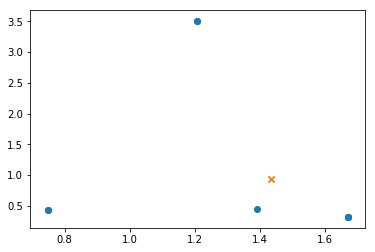

In [16]:
E = echantillonLS(set_exemples,10,True)
plot2DSet(E)

<font size="+1">**[Q]**</font> Ecrire la classe <code>ClassifierBaggingTree</code>, dérivée de la classe <code>Classifier</code>, qui permet d'implémenter un bagging d'arbres de décision. Les spécifications de cette classe sont :
- la création de l'ensemble nécessite les paramètres suivants : 
    - le nombre d'arbres à construire, 
    - le pourcentage d'exemples de la base d'apprentissage utilisés pour constituer un échantillon, 
    - la valeur de seuil d'entropie pour arrêter la construction de chaque arbre, 
    - et un booléen qui précise si un échantillon est tiré avec ou sans remise
- l'apprentissage (méthode <code>train()</code>) construit autant d'arbres que précisé à la création. Chaque arbre est construit à partir d'un échantillon de la base d'apprentissage (<code>LabeledSet</code>) donnée en argument. Les arbres construits sont stockés dans un ensemble Python.
- la prédiction (méthode <code>predict()</code>) classe un exemple par vote de tous les arbres de la forêt. Si la somme des votes est positive ou nulle, la classe rendue est +1, sinon, la classe rendue est -1.

In [32]:
class ClassifierBaggingTree(Classifier):
    def __init__(self, nb_tree, echantillon, entropie, remise):
        self.nb_tree = nb_tree
        self.echantillon = echantillon
        self.entropie = entropie
        self.remise = remise
        self.liste = []
        
    def train(self, labeledSet):
        for i in range(self.nb_tree):
            arbre = ArbreDecision(self.entropie)  # Creation d'un arbre
            pourcentage = int(labeledSet.size()*self.echantillon)  # On recupere le nombre d'exemple dont nous avons besoin
            arbre.train(echantillonLS(labeledSet, pourcentage, self.remise))  # On entraine l'arbre cree avec un sous labeledSet
            self.liste.append(arbre)  # On ajoute l'arbre a la liste
            
    
    def predict(self, x):
        somme = 0  # somme des predictions de chaque arbres
        for i in self.liste:
            somme += i.predict(x)  
        if somme >= 0:  # Si la somme des predictions est nul ou > 0 alors on renvoie +1 sinon -1
            return 1
        else:
            return -1

('exemple:', 0, ' vraie classe = ', array([1]), '- classe trouvee = ', 1)
('exemple:', 1, ' vraie classe = ', array([1]), '- classe trouvee = ', 1)
('exemple:', 2, ' vraie classe = ', array([1]), '- classe trouvee = ', 1)
('exemple:', 3, ' vraie classe = ', array([1]), '- classe trouvee = ', 1)
('exemple:', 4, ' vraie classe = ', array([1]), '- classe trouvee = ', 1)
('exemple:', 5, ' vraie classe = ', array([1]), '- classe trouvee = ', 1)
('exemple:', 6, ' vraie classe = ', array([1]), '- classe trouvee = ', -1)
('exemple:', 7, ' vraie classe = ', array([1]), '- classe trouvee = ', 1)
('exemple:', 8, ' vraie classe = ', array([1]), '- classe trouvee = ', 1)
('exemple:', 9, ' vraie classe = ', array([1]), '- classe trouvee = ', 1)
('exemple:', 10, ' vraie classe = ', array([-1]), '- classe trouvee = ', -1)
('exemple:', 11, ' vraie classe = ', array([-1]), '- classe trouvee = ', -1)
('exemple:', 12, ' vraie classe = ', array([-1]), '- classe trouvee = ', -1)
('exemple:', 13, ' vraie cla

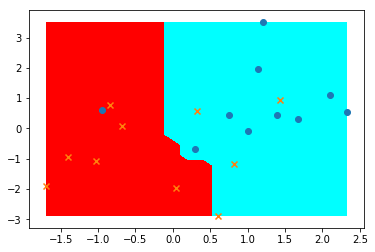

In [33]:
foret = ClassifierBaggingTree(10,0.3,0.0,True)
foret.train(set_exemples)
for i in range(set_exemples.size()):
    print("exemple:",i," vraie classe = ", set_exemples.getY(i), "- classe trouvee = ", foret.predict(set_exemples.getX(i)))
    
plot_frontiere(set_exemples,foret,20)
plot2DSet(set_exemples) 

print("accuracy totale:",foret.accuracy(set_exemples))

### Expérimentations

<font size="+1">**[Q]**</font> Expérimenter l'algorithme précédent de la façon suivante :
- générer une base d'apprentissage $X$ contenant au moins 1000 exemples ;
- réaliser un échantillon de cette base contenant 50 exemples de chaque classe. Soit $E$ cet échantillon, et soit $F$ l'ensemble des exemples de $X$ qui ne sont pas dans $E$ ;
- réaliser un apprentissage par bagging sur $F$ et évaluer le taux de prédiction du modèle obtenu sur $E$ ;
- construire la courbe donnant le taux de prédiction obtenu en augmentant la taille de la forêt d'arbres de 1 à 100 arbres. 

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: RuntimeWarning: covariance is not positive-semidefinite.


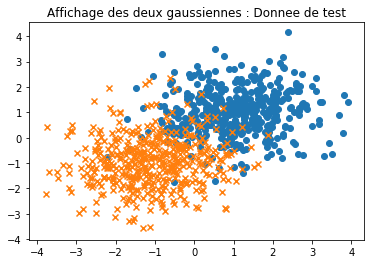

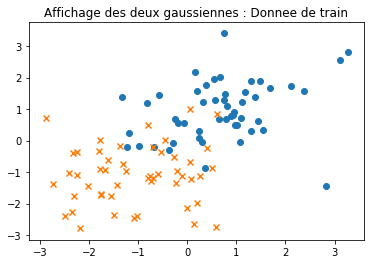

In [52]:
# Creation des Gaussiennes
# Exemple avec deux gaussiennes qui se "melangent"
mean1 = [1, 1]
mean2 = [-1, -1]
mat1 = np.random.multivariate_normal(mean1, [[0.1, 1],[1, 0.1]], 500).T
mat2 = np.random.multivariate_normal(mean2, [[0.1, 1],[1, 0.1]], 500).T
data2 = LabeledSet(2)

t1 = random.sample([i for i in range(500)], 50)
t2 = random.sample([i for i in range(500)], 50)  #50 nombres au hasard entre 0 et 499

set_test = LabeledSet(2)
big_set = LabeledSet(2)

for i in range(len(mat1[0])):  
    if i in t1:  # Si il fait parti des nombres tire aleatoirement on l'ajoute au labeledSet de test
        set_test.addExample([mat1[0][i], mat1[1][i]], 1)
    else:
        data2.addExample([mat1[0][i], mat1[1][i]], 1)
    big_set.addExample([mat1[0][i], mat1[1][i]], 1)
   
        
for i in range(len(mat1[0])):  # On ajoute les exemples au labeledSet
    if i in t2:
        set_test.addExample([mat2[0][i], mat2[1][i]], -1)
    else:
        data2.addExample([mat2[0][i], mat2[1][i]], -1)
    big_set.addExample([mat2[0][i], mat2[1][i]], -1)

# Affichage
plt.title("Affichage des deux gaussiennes : Donnee de test")
plot2DSet(data2)
plt.show()

plt.title("Affichage des deux gaussiennes : Donnee de train")
plot2DSet(set_test)
plt.show()





In [35]:
# Réaliser un apprentissage par bagging sur E et évaluer le taux de prédiction du modèle sur F
foret20 =  ClassifierBaggingTree(20,0.1,0.0,True)
foret20.train(data2)
print("Bagging : 20 trees: accuracy totale: train=%.4f test=%.4f"%(foret20.accuracy(set_test),foret20.accuracy(data2)))

Bagging : 20 trees: accuracy totale: train=0.9400 test=0.9211


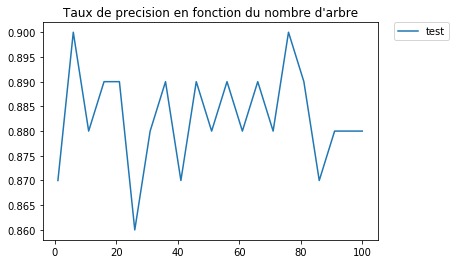

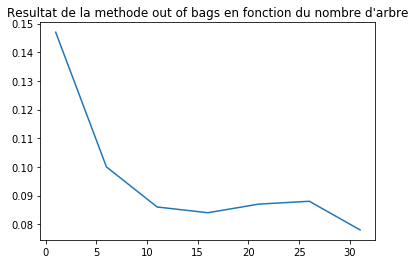

In [53]:
#################################
#CE TEST PREND ENVIRON 5 MINUTES#
#################################


accuracy_test = []
oob = []  # prediction de la methode out of bags en fonction du nombre d'abre
nb_arbre = [i for i in range(1,101, 5)] + [100]

for i in nb_arbre:
    f = ClassifierBaggingTree(i,0.1,0.0,True)  # On cree un classifieur avec i arbre
    f.train(data2)  # On lance l'apprentissage des i arbres qui auront 100 exemples
    accuracy_test.append(f.accuracy(set_test))
    if i < 32:
        oob.append(out_of_bags(f))
    
plt.plot(nb_arbre, accuracy_test, label="test")
plt.title("Taux de precision en fonction du nombre d'arbre")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.plot(nb_arbre[0:7], oob)
plt.title("Resultat de la methode out of bags en fonction du nombre d'arbre")
plt.show()

### Evaluation par la méthode "Out Of Bags"

<font size="+1">**[Q]**</font> Sur les mêmes données, réaliser une évaluation par la méthode "Out Of Bags" vue en cours. Construire la courbe donnant le taux de prédiction OOB en fonction de la taille de la forêt d'arbres.



In [93]:
def out_of_bags(f):
    erreur = 0  # Nombre d'erreurs
    total = 0  # Nombre total d'exemple
    for i in range(big_set.size()):  # Pour chaque exemple
        somme = 0
        for j in f.liste:  # Pour chaque arbre
            is_in = False  # Si l'arbre n'a pas ete entraine avec cet exemple
            for k in range(j.set.size()):
                if np.array_equal(big_set.getX(i), j.set.getX(k)):
                    is_in = True
            if not is_in:  # Alors on ajoute sa prediction a la somme
                somme += j.predict(big_set.getX(i))
        if somme >= 0 and big_set.getY(i) == -1 or somme < 0 and big_set.getY(i) == 1:  # Si la somme (prediction globale)
            # se trompe, on augmente le nombre d'erreurs
            erreur += 1
        total += 1
    return float(erreur)/total
        

## Etape 3: Bagging de perceptrons

<font size="+1">**[Q]**</font> Ecrire et tester la classe <code>ClassifierBaggingPerceptron</code> qui implémente l'algorithme du bagging pour le perceptron.

In [86]:
import copy
class ClassifierBaggingPerceptron(Classifier):
    def __init__(self, nb_perceptron, input_dimension, learning_rate, echantillon, remise, nb_iteration):
        self.nb_perceptron = nb_perceptron
        self.input_dimension = input_dimension
        self.learning_rate = learning_rate
        self.echantillon = echantillon
        self.remise = remise
        self.liste = []
        self.nb_iteration = nb_perceptron
        
    def train(self, labeledSet):
        for i in range(self.nb_perceptron):
            perceptron = Perceptron(self.input_dimension, self.learning_rate, self.nb_iteration)  
            pourcentage = int(labeledSet.size()*self.echantillon)  
            perceptron.iterate(echantillonLS(labeledSet, pourcentage, self.remise))  
            self.liste.append(perceptron)  
            
    
    def predict(self, x):
        somme = 0  # somme des predictions de chaque arbres
        for i in self.liste:
            somme += i.predict(x)  
        if somme >= 0:  # Si la somme des predictions est nul ou > 0 alors on renvoie +1 sinon -1
            return 1
        else:
            return -1
        
        
class Perceptron(Classifier):
    
    def __init__(self, input_dimension, learning_rate, n):
        self.input_dimension = input_dimension
        self.learning_rate = learning_rate
        self.w = np.random.rand(input_dimension) * 2 - 1
        self.nombre_iterations = n
    
    def predict(self, x):
        return np.dot(x, self.w)
    
    def train(self, labeledSet):
        self.set = labeledSet
        alea = [k for k in range(labeledSet.size())]
        random.shuffle(alea)
        for j in alea:
            if self.predict(labeledSet.getX(j))*labeledSet.getY(j) < 0:
                self.w = self.w + self.learning_rate * labeledSet.getY(j) * labeledSet.getX(j)
                
    def iterate(self, training):
        for i in range(self.nombre_iterations):
            old_w = copy.deepcopy(self.w)
            self.train(training)
            if np.array_equal(old_w, self.w):
                #print "Converge"
                break
                    
                

In [91]:
class ClassifierBaggingPerceptronKernel(Classifier):
    def __init__(self, nb_perceptron, input_dimension, learning_rate, echantillon, remise, kernel, n):
        self.nb_perceptron = nb_perceptron
        self.input_dimension = input_dimension
        self.learning_rate = learning_rate
        self.echantillon = echantillon
        self.remise = remise
        self.kernel = kernel
        self.liste = []
        self.n = n
        
    def train(self, labeledSet):
        for i in range(self.nb_perceptron):
            perceptronk = PerceptronKernel(self.input_dimension, self.learning_rate, self.kernel, self.n)  
            pourcentage = int(labeledSet.size()*self.echantillon)  
            perceptronk.iterate(echantillonLS(labeledSet, pourcentage, self.remise))  
            self.liste.append(perceptronk)  
            
    
    def predict(self, x):
        somme = 0  # somme des predictions de chaque arbres
        for i in self.liste:
            somme += i.predict(x)  
        if somme >= 0:  # Si la somme des predictions est nul ou > 0 alors on renvoie +1 sinon -1
            return 1
        else:
            return -1



class PerceptronKernel(Classifier):
    def __init__(self,dimension_kernel,learning_rate,kernel, n):
        self.dimension_kernel = dimension_kernel
        self.learning_rate = learning_rate
        self.kernel = kernel
        self.w = np.random.rand(dimension_kernel) * 2 - 1 
        self.nb_iterations = n
        
    #Permet de calculer la prediction sur x => renvoie un score
    def predict(self,x):
        x = self.kernel.transform(x)
        a = sum(self.w[i]*x[i] for i in range(len(x)))
        return a
    
    #Permet d'entrainer le modele sur un ensemble de données
    def train(self,labeledSet):
        alea = [k for k in range(labeledSet.size())]
        random.shuffle(alea)
        for j in alea:
            t = self.kernel.transform(labeledSet.getX(j))
            if self.predict(t)*labeledSet.getY(j) < 0:
                self.w = self.w + self.learning_rate * labeledSet.getY(j) * t   
                
    def iterate(self, training):
        for i in range(self.nb_iterations):
            old_w = copy.deepcopy(self.w)
            self.train(training)
            if np.array_equal(old_w, self.w):
                break                   
    

class KernelPoly:
    def transform(self,x):
            return np.asarray([x[0], x[1], x[0]*x[1], x[0]**2, x[1]**2, 1])

In [38]:
# un exemple d'utilisation:
percep=ClassifierBaggingPerceptron(20, 2, 0.01, 0, 0.1, True)           
percep.train(data2)            
    
print("accuracy:", percep.accuracy(set_test))    


('accuracy:', 0.93)


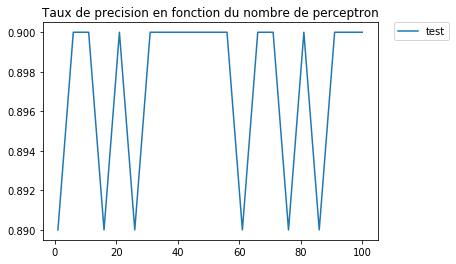

In [87]:
#################################
#CE TEST PREND ENVIRON 5 MINUTES#
#################################


accuracy_test = []
oob = []  # prediction de la methode out of bags en fonction du nombre d'abre
nb_arbre = [i for i in range(1,101, 5)] + [100]

for i in nb_arbre:
    f = ClassifierBaggingPerceptron(i, 2, 0.01, 0.1, True, 100)   # On cree un classifieur avec i arbre
    f.train(data2)  # On lance l'apprentissage des i arbres qui auront 100 exemples
    accuracy_test.append(f.accuracy(set_test))
    #oob.append(out_of_bags(f))
    
plt.plot(nb_arbre, accuracy_test, label="test")
plt.title("Taux de precision en fonction du nombre de perceptron")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#plt.plot(nb_arbre, oob)
#plt.title("Resultat de la methode out of bags en fonction du nombre de perceptron")
#plt.show()

## Etape 4: expérimentation

<font size="+1">**[Q]**</font> Appliquer l'algorithme de bagging d'arbres de décision sur d'autres bases d'apprentissage. Construire la courbe donnant le taux de prédiction pour une forêt d'arbres variant de 1 à 200 arbres. 

Réaliser ensuite la même expérimentation avec un bagging de perceptrons.

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: RuntimeWarning: covariance is not positive-semidefinite.


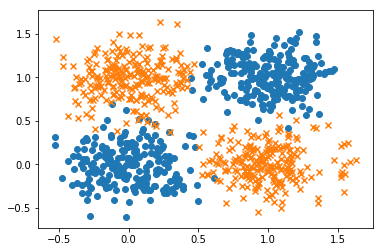

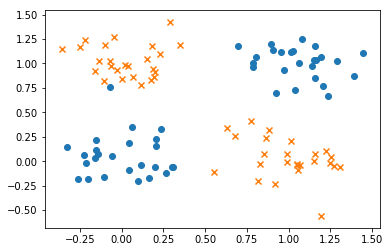

In [69]:
# Test sur le XOR

#Initialisation XOR
set_test_xor = LabeledSet(2) 
data = LabeledSet(2)

mean1 = [0, 0]
mean2 = [1, 1]
mean3 = [1, 0]
mean4 = [0, 1]
mat1 = np.random.multivariate_normal(mean1, [[0,0.05],[0.05,0]], 250).T
mat2 = np.random.multivariate_normal(mean2, [[0,0.05],[0.05,0]], 250).T
mat3 = np.random.multivariate_normal(mean3, [[0,0.05],[0.05,0]], 250).T
mat4 = np.random.multivariate_normal(mean4, [[0,0.05],[0.05,0]], 250).T

t1 = random.sample([i for i in range(250)], 25)
t2 = random.sample([i for i in range(250)], 25)
t3 = random.sample([i for i in range(250)], 25)
t4 = random.sample([i for i in range(250)], 25)

for i in range(len(mat1[0])):
    if i not in t1:
        data.addExample([mat1[0][i], mat1[1][i]], 1)
    else:
        set_test_xor.addExample([mat1[0][i], mat1[1][i]], 1)
    if i not in t2:
        data.addExample([mat2[0][i], mat2[1][i]], 1)
    else:
        set_test_xor.addExample([mat2[0][i], mat2[1][i]], 1)
for i in range(len(mat2[0])):
    if i not in t3:
        data.addExample([mat3[0][i], mat3[1][i]], -1)
    else:
        set_test_xor.addExample([mat3[0][i], mat3[1][i]], -1)
    if i not in t4:
        data.addExample([mat4[0][i], mat4[1][i]], -1)
    else:
        set_test_xor.addExample([mat4[0][i], mat4[1][i]], -1)
        
plot2DSet(data)
plt.show()

plot2DSet(set_test_xor)
plt.show()

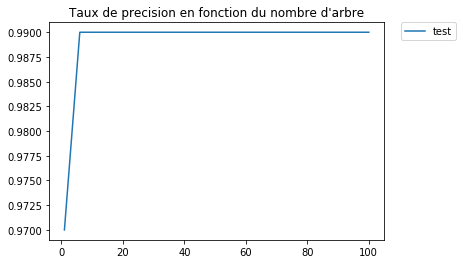

In [70]:
accuracy_test = []
nb_arbre = [i for i in range(1,101, 5)] + [100]


for i in nb_arbre:
    f = ClassifierBaggingTree(i,0.1,0.0,True)  # On cree un classifieur avec i arbre
    f.train(data)  # On lance l'apprentissage des i arbres qui auront 100 exemples
    accuracy_test.append(f.accuracy(set_test_xor))
    
    
plt.plot(nb_arbre, accuracy_test, label="test")
plt.title("Taux de precision en fonction du nombre d'arbre")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91
96
100


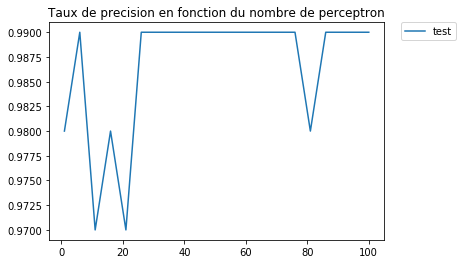

In [92]:
#################################
#CE TEST PREND ENVIRON 5 MINUTES#
#################################


accuracy_test = []
nb_arbre = [i for i in range(1,101, 5)] + [100]

for i in nb_arbre:
    f = ClassifierBaggingPerceptronKernel(i, 6, 0.01, 0.1, True, KernelPoly(), 100)   # On cree un classifieur avec i arbre
    f.train(data)  # On lance l'apprentissage des i arbres qui auront 100 exemples
    accuracy_test.append(f.accuracy(set_test_xor))
    
plt.plot(nb_arbre, accuracy_test, label="test")
plt.title("Taux de precision en fonction du nombre de perceptron")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
